# Application of the project : 

This project is highly applicable in financial markets
where timely sentiment analysis can give traders and
investors a competitive edge. 

It can be used by financial
institutions, portfolio managers, and retail investors to
assess market sentiment on specific stocks, improving
decision-making related to buying, selling, or holding
assets. 

Furthermore, financial analysts can benefit from
the project's ability to assess specific aspects of a
company's operations—such as earnings, management
decisions, or new product launches—helping them form
more accurate predictions about market behavior.

# Project Description :

The primary problem this project aims to solve is
the limitation of conventional models in accounting for
real-time sentiment, which is crucial for understanding market reactions.

Traditional stock analysis focuses on
past price data, but this approach overlooks how news
events and public sentiment can drive immediate changes
in stock direction.

This project seeks to bridge this
gap by employing Natural Language Processing (NLP)
techniques combined with machine learning models to
determine stock sentiment categories (bullish, bearish,
holding) based on news coverage.

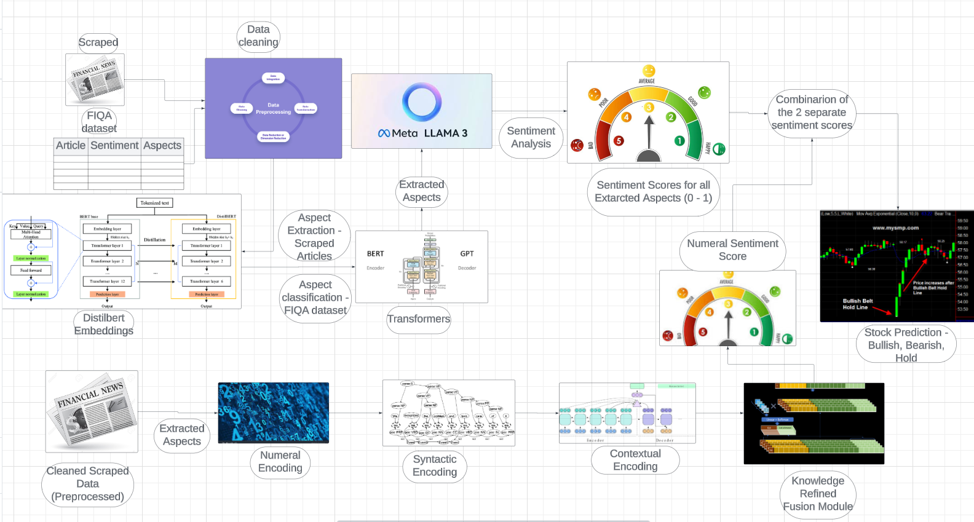


What makes this project unique is its integration of
Aspect-Based Sentiment Analysis (ABSA), powered by
a DistilBERT-based classifier, for extracting sentiment
toward specific financial aspects along with another
sentiment analyzer that takes into account the numerical,
contextual and syntactic context of the article - all 3 of
which are combined into a knowledge fusion module that
in turn provides another sentiment score.

# Packages/Libraries to be installed

In [1]:
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install transformers
!pip install torch
!pip install groq
!pip install yfinance
clear_output()

In [3]:
import s3fs
import pandas as pd
import json
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import torch
import torch.nn as nn
import torch.nn.functional as F
import spacy
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import re
from string import punctuation
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline, DistilBertTokenizer, AutoModelForSequenceClassification
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling1D, Lambda
import tensorflow as tf
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from groq import Groq
import os
import yfinance as yf
from datetime import datetime, timedelta
from collections import Counter

In [ ]:
import pkg_resources

# Updated list without standard library packages
packages = {
    's3fs', 'pandas', 'nltk', 'torch', 'spacy', 'numpy', 'tqdm','transformers', 'tensorflow', 'matplotlib', 
    'groq', 'yfinance'
}

for package in packages:
    try:
        version = pkg_resources.get_distribution(package).version
        print(f"{package}: {version}")
    except pkg_resources.DistributionNotFound:
        print(f"{package} is not installed.")


# Versions of Installed Packages

**s3fs: 2024.6.1
tensorflow: 2.16.1
groq: 0.11.0
pandas: 2.2.3
spacy: 3.8.2
numpy: 1.26.4
yfinance: 0.2.48
matplotlib: 3.7.5
tqdm: 4.66.4
transformers: 4.45.1
torch: 2.4.0+cpu
**nltk: 3.2.4

# **1 Data Collection**


India News Data: We collected the news articles for the companies INFOSYS, BRITTANIA, ASIAN PAINTS, ONGC and AXIS BANK from Publicly available financial news sources. Each record had the following attributes: Headline, Link, Type, Date and Description

Aspect Based Data: The FIQA 2017 dataset was used for training the model on aspect extraction from sentences. Each record had the following attributes: Headline, Aspect, Company name and Sentiment Score.

Target Company Based Data : The SemEval Task 5 Dataset of 2017, which includes Company name, Headline and Sentiment Score.

## **1.1 Collecting News Data for Indian Companies**

### 1.1.1 Infosys

In [ ]:
import s3fs
import pandas as pd

uri = "s3://desiquant/data/news/INFY.parquet.gz"

s3_params = {
"endpoint_url": "https://cbabd13f6c54798a9ec05df5b8070a6e.r2.cloudflarestorage.com",
"key": "5c8ea9c516abfc78987bc98c70d2868a",
"secret": "0cf64f9f0b64f6008cf5efe1529c6772daa7d7d0822f5db42a7c6a1e41b3cadf",
"client_kwargs": {
    "region_name": "auto"
    },
}

df = pd.read_parquet(uri, storage_options=s3_params)
df.to_csv('infosys.csv', index=False)

In [ ]:
df.head()

### 1.1.2 Asian Paints

In [ ]:
import s3fs
import pandas as pd

uri = "s3://desiquant/data/news/ASIANPAINT.parquet.gz"

s3_params = {
"endpoint_url": "https://cbabd13f6c54798a9ec05df5b8070a6e.r2.cloudflarestorage.com",
"key": "5c8ea9c516abfc78987bc98c70d2868a", # FREE credentials for public access!
"secret": "0cf64f9f0b64f6008cf5efe1529c6772daa7d7d0822f5db42a7c6a1e41b3cadf", # FREE credentials for public access!
"client_kwargs": {
    "region_name": "auto"
    },
}

df = pd.read_parquet(uri, storage_options=s3_params)
df.to_csv('asianpaints.csv', index=False)

In [ ]:
df.head()

### 1.1.3 ONGC

In [ ]:
import s3fs
import pandas as pd

uri = "s3://desiquant/data/news/ONGC.parquet.gz"

s3_params = {
"endpoint_url": "https://cbabd13f6c54798a9ec05df5b8070a6e.r2.cloudflarestorage.com",
"key": "5c8ea9c516abfc78987bc98c70d2868a",
"secret": "0cf64f9f0b64f6008cf5efe1529c6772daa7d7d0822f5db42a7c6a1e41b3cadf", 
"client_kwargs": {
    "region_name": "auto"
    },
}

df = pd.read_parquet(uri, storage_options=s3_params)
df.to_csv('ongc.csv', index = False)

In [ ]:
df.head()

### 1.1.4 Axis Bank

In [ ]:
import s3fs
import pandas as pd

uri = "s3://desiquant/data/news/AXISBANK.parquet.gz"

s3_params = {
"endpoint_url": "https://cbabd13f6c54798a9ec05df5b8070a6e.r2.cloudflarestorage.com",
"key": "5c8ea9c516abfc78987bc98c70d2868a", # FREE credentials for public access!
"secret": "0cf64f9f0b64f6008cf5efe1529c6772daa7d7d0822f5db42a7c6a1e41b3cadf", # FREE credentials for public access!
"client_kwargs": {
    "region_name": "auto"
    },
}

df = pd.read_parquet(uri, storage_options=s3_params)
df.to_csv('axisbank.csv', index = False)

In [ ]:
df.head()

### 1.1.5 Brittania

In [ ]:
import s3fs
import pandas as pd

uri = "s3://desiquant/data/news/BRITANNIA.parquet.gz"

s3_params = {
"endpoint_url": "https://cbabd13f6c54798a9ec05df5b8070a6e.r2.cloudflarestorage.com",
"key": "5c8ea9c516abfc78987bc98c70d2868a", # FREE credentials for public access!
"secret": "0cf64f9f0b64f6008cf5efe1529c6772daa7d7d0822f5db42a7c6a1e41b3cadf", # FREE credentials for public access!
"client_kwargs": {
    "region_name": "auto"
    },
}

df = pd.read_parquet(uri, storage_options=s3_params)
df.to_csv('brittania.csv', index = False)

In [ ]:
df.head()

## 1.2 FIQA Dataset

In [ ]:
import json
with open("/kaggle/input/fiqa-dataset/task1_headline_ABSA_train.json", 'r') as f:
    data = json.load(f)
print(f"Sentence : {data['1']['sentence']}")
print(f"Company : {data['1']['info'][0]['target']}")
print(f"Sentiment Score : {data['1']['info'][0]['sentiment_score']}")
print(f"Aspects : {data['1']['info'][0]['aspects']}")

## 1.3 SemEval Dataset

In [ ]:
with open("/kaggle/input/semeval/Headline_Trainingdata.json", 'r') as f:
    data = json.load(f)
print(f"Sentence : {data[0]['title']}")
print(f"Company : {data[0]['company']}")
print(f"Sentiment Score : {data[0]['sentiment']}")

# 2 Encoding Based Sentiment Analysis

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel, BertTokenizer
import spacy
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import json
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import re

# Constants
FIXED_NUMERAL_LENGTH = 8 # Max allowed numeral length
MAX_ASPECT_DISTANCE = 10 # Max allowed distance in aspect based dependency tree
MAX_NUMERALS = 5 # Max allowed numerals in a sentence

In [ ]:
nlp = spacy.load('en_core_web_sm')

## **2.1 Numeral Encoder**
Numerals are encoded into the following parts: Size, Category, Aspect Distance.


Size of a numeral is captured by character and magnitude embedding. Character embedding comprises the embedding of digits, decimal point, and negative sign. Magnitude embedding is the position index embedding of each character.


The numerals are categorized into four classes: Percentage, Monetary, Temporal, and Other( Abstract )

In [ ]:
def extract_numerals(sentence):
    """Extract numerals and categorize them."""
    numerals = re.findall(r"[-]?\d*\.?\d+", sentence)
    return numerals
def categorize_numeral(numerals, sentence):
    """Categorize each numeral in the sentence based on its local context."""
    sentence = sentence.lower()
   
    categories = []
    for numeral in numerals:
        numeral_pos = sentence.find(numeral)  # Find the position of the numeral
        window_size = 10  # Number of characters to look around the numeral
        # Get local context around the numeral
        start = max(0, numeral_pos - window_size)
        end = min(len(sentence), numeral_pos + len(numeral) + window_size)
        local_context = sentence[start:end]
        
        # Categorization rules
        if '%' in local_context or 'percent' in local_context or 'per cent' in local_context:
            categories.append('percentage')
        elif '$' in local_context or 'dollar' in local_context or '€' in local_context or 'rs' in local_context or '₹' in local_context:
            categories.append('monetary')
        elif re.match(r'^\d{4}$', numeral):  # Exactly 4 digits indicate temporal
            categories.append('temporal')
        else:
            categories.append('other')
    return categories
def calculate_aspect_distance(sentence, numeral):
    """
    Calculate aspect distance from the numeral using spaCy's dependency tree.
    For simplicity, assuming 'aspect' is the main subject of the sentence.
    """
    doc = nlp(sentence)
    # Identify the main subject as the aspect
    aspect = None
    for token in doc:
        if token.dep_ in ('nsubj', 'nsubjpass') and token.pos_ in ('NOUN', 'PROPN'):
            aspect = token
            break
    if not aspect:
        # Fallback: choose the first noun as aspect
        for token in doc:
            if token.pos_ in ('NOUN', 'PROPN'):
                aspect = token
                break
    if not aspect:
        return 0  # Default distance if aspect is not found
    
    distances = []
    for token in doc:
        if numeral in token.text:
            distance = abs(aspect.i - token.i)
            distances.append(distance if distance < MAX_ASPECT_DISTANCE else MAX_ASPECT_DISTANCE - 1)
    if not distances:
        return 0
    return min(distances) 

import torch

def get_embeddings(sentence, label_encoder, fixed_length=10, max_numerals=5):
    """
    Function to extract numerals, categorize them, and compute aspect distances for a given sentence.
    It returns three embeddings: 
    - Character tensor
    - Category tensor
    - Distance tensor
    """
    # Extract numerals and categories
    numerals = extract_numerals(sentence)
    categories = categorize_numeral(numerals, sentence)
    distances = [calculate_aspect_distance(sentence, num) for num in numerals]

    # Limit the number of numerals per sentence (optional)
    num_numerals = len(numerals)
    if num_numerals > max_numerals:
        numerals = numerals[:max_numerals]
        categories = categories[:max_numerals]
        distances = distances[:max_numerals]
        num_numerals = max_numerals

    # Padding numerals to a fixed length and converting to indices
    padded_chars = []
    for num in numerals:
        chars = list(num)
        char_indices = []
        for c in chars:
            if c == '.':
                char_indices.append(11)
            elif c == '-':
                char_indices.append(12)
            else:
                char_indices.append(int(c) + 1)  # '0' ->1, '1'->2, ..., '9'->10

        # Left-pad with 0 to the fixed length
        if len(char_indices) > fixed_length:
            char_indices = char_indices[-fixed_length:]
        else:
            char_indices = [0] * (fixed_length - len(char_indices)) + char_indices
        padded_chars.append(char_indices)

    # If fewer numerals than max_numerals, pad with zeros and default categories/distances
    while len(padded_chars) < max_numerals:
        padded_chars.append([0] * fixed_length)
        categories.append('other')  # Default category
        distances.append(0)  # Default distance

    # Convert categories to indices
    category_indices = label_encoder.transform(categories)

    # Clip distances to a maximum value
    clipped_distances = [min(d, MAX_ASPECT_DISTANCE - 1) for d in distances]

    # Convert to tensors
    chars_tensor = torch.tensor(padded_chars, dtype=torch.long)  # (max_numerals, fixed_length)
    categories_tensor = torch.tensor(category_indices, dtype=torch.long)  # (max_numerals,)
    distances_tensor = torch.tensor(clipped_distances, dtype=torch.long)  # (max_numerals,)

    return chars_tensor, categories_tensor, distances_tensor
# 3. Embedding Functions
class NumeralEncoder(nn.Module):
    def __init__(self, char_embed_size=10, cat_embed_size=5, dis_embed_size=5, num_kernels=16, kernel_size=3):
        super(NumeralEncoder, self).__init__()
        self.char_embed = nn.Embedding(13, char_embed_size, padding_idx=0)  # 0-9, '.', '-', padding
        
        self.cat_label_encoder = LabelEncoder()
        self.cat_label_encoder.fit(['percentage', 'monetary', 'temporal', 'other'])
        self.cat_embed = nn.Embedding(len(self.cat_label_encoder.classes_), cat_embed_size)
        
        self.dis_embed = nn.Embedding(MAX_ASPECT_DISTANCE, dis_embed_size)
        
        self.conv = nn.Conv2d(1, num_kernels, kernel_size=(kernel_size, char_embed_size + cat_embed_size + dis_embed_size))
        self.pool = nn.MaxPool2d((2, 1))
        self.flatten = nn.Flatten()
        
        # Calculate output size
        self.output_size = num_kernels * ((FIXED_NUMERAL_LENGTH - kernel_size + 1) // 2)
        
    def forward(self, chars, categories, distances):
        """
        chars: Tensor of shape (batch_size, num_numerals, o)
        categories: Tensor of shape (batch_size, num_numerals)
        distances: Tensor of shape (batch_size, num_numerals)
        """
        batch_size, num_numerals, o = chars.size()
        # Reshape for embedding lookup
        chars = chars.view(-1, o)  # (batch_size * num_numerals, o)
        categories = categories.view(-1)
        distances = distances.view(-1)
        
        # Embeddings
        char_embeds = self.char_embed(chars)  # (batch_size * num_numerals, o, char_embed_size)
        cat_embeds = self.cat_embed(categories)  # (batch_size * num_numerals, cat_embed_size)
        dis_embeds = self.dis_embed(distances)  # (batch_size * num_numerals, dis_embed_size)
        
        # Expand cat_embeds and dis_embeds to match character embeddings
        cat_embeds = cat_embeds.unsqueeze(1).repeat(1, o, 1)  # (batch_size * num_numerals, o, cat_embed_size)
        dis_embeds = dis_embeds.unsqueeze(1).repeat(1, o, 1)  # (batch_size * num_numerals, o, dis_embed_size)
        
        # Concatenate embeddings
        combined_embeds = torch.cat([char_embeds, cat_embeds, dis_embeds], dim=2)  # (batch_size * num_numerals, o, total_embed_size)
        
        # Add channel dimension for CNN
        combined_embeds = combined_embeds.unsqueeze(1)  # (batch_size * num_numerals, 1, o, total_embed_size)
        
        # Convolution
        conv_out = self.conv(combined_embeds)  # (batch_size * num_numerals, num_kernels, o - kernel_size +1, 1)
        conv_out = torch.relu(conv_out)
        
        # Pooling
        pooled_out = self.pool(conv_out).squeeze(3)  # (batch_size * num_numerals, num_kernels, pooled_height)
        
        # Flatten
        flattened = self.flatten(pooled_out)  # (batch_size * num_numerals, num_kernels * pooled_height)
        
        # Reshape back to (batch_size, num_numerals, -1)
        final_embedding = flattened.view(batch_size, num_numerals, -1)
        return final_embedding  # (batch_size, num_numerals, num_kernels * pooled_height)

## 2.2 Sytactic Encoder

This encoding tactic utilizes a dependency relation matrix passed to a GCN along with the BERT Embeddings to get syntactic encodings.

In [ ]:
class SyntacticEncoder(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', hidden_size=768, num_gcn_layers=2, max_seq_length=128):
        super(SyntacticEncoder, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.gcn_layers = nn.ModuleList([
            GraphConvolution(hidden_size, hidden_size)
            for _ in range(num_gcn_layers)
        ])
        self.nlp = spacy.load('en_core_web_sm')
        self.tokenizer = BertTokenizer.from_pretrained(bert_model_name)
        self.max_seq_length = max_seq_length
        self.hidden_size = hidden_size
        
    def align_tokens_and_create_matrix(self, sentence, bert_tokens):
        # Process with spaCy
        doc = self.nlp(sentence)
        
        # Create dependency matrix for spaCy tokens
        spacy_tokens = [token.text for token in doc]
        n_spacy = len(spacy_tokens)
        spacy_dep_matrix = np.zeros((n_spacy, n_spacy))
        
        # Fill spaCy dependency matrix
        for token in doc:
            if token.head is token:  # Root token
                continue
            spacy_dep_matrix[token.i, token.head.i] = 1
            spacy_dep_matrix[token.head.i, token.i] = 1
        
        # Create BERT dependency matrix
        n_bert = len(bert_tokens)
        bert_dep_matrix = np.zeros((n_bert, n_bert))
        
        # Add self-loops
        np.fill_diagonal(bert_dep_matrix, 1)
        
        # Add uniform connections for special tokens
        special_weight = 0.1
        bert_dep_matrix[0, :] = special_weight  # [CLS]
        bert_dep_matrix[:, 0] = special_weight
        
        if '[SEP]' in bert_tokens:
            sep_idx = bert_tokens.index('[SEP]')
            bert_dep_matrix[sep_idx, :] = special_weight
            bert_dep_matrix[:, sep_idx] = special_weight
            
        return torch.FloatTensor(bert_dep_matrix).to(self.device)

    def forward(self, input_ids, attention_mask, sentence):
        # Get BERT embeddings
        with torch.no_grad():
            bert_outputs = self.bert(input_ids, attention_mask=attention_mask)
        hidden_states = bert_outputs.last_hidden_state
        
        # Get BERT tokens
        tokens = self.tokenizer.convert_ids_to_tokens(input_ids[0])
        
        # Create aligned dependency matrix
        adj_matrix = self.align_tokens_and_create_matrix(sentence, tokens)
        
        # Apply GCN layers
        x = hidden_states[0]  # Take first item from batch
        for gcn_layer in self.gcn_layers:
            x = gcn_layer(x, adj_matrix)
            x = F.relu(x)
        
        # Pad sequence to max_seq_length
        if x.size(0) < self.max_seq_length:
            padding = torch.zeros(self.max_seq_length - x.size(0), self.hidden_size, device=self.device)
            x = torch.cat([x, padding], dim=0)
        else:
            x = x[:self.max_seq_length]
            
        return x

## 2.3 Contextual Encoder

This encoding technique uses aspect aware attention and self-attention to acquire better semantic features. Aspect term is takes as query to calculate multi-head attention scores.

The attention score is then passed to a GCN to get Contextual Encodings

In [ ]:
class ContextualEncoder(nn.Module):
    def __init__(self, bert_model='bert-base-uncased', hidden_size=768, num_heads=8):
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.bert = BertModel.from_pretrained(bert_model)
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        
        # Initialize parameters
        self.W_a = nn.Parameter(torch.randn(hidden_size, hidden_size) / np.sqrt(hidden_size))
        self.W_k = nn.Parameter(torch.randn(hidden_size, hidden_size) / np.sqrt(hidden_size))
        self.W_Q = nn.Parameter(torch.randn(hidden_size, hidden_size) / np.sqrt(hidden_size))
        self.W_con = nn.Parameter(torch.randn(hidden_size, hidden_size) / np.sqrt(hidden_size))
        self.b_con = nn.Parameter(torch.zeros(hidden_size))
        self.b = nn.Parameter(torch.zeros(1))
    
    def forward(self, input_ids, attention_mask, aspect_mask):
        # Get BERT outputs
        with torch.no_grad():
            outputs = self.bert(input_ids, attention_mask=attention_mask)
        H = outputs.last_hidden_state
        
        # Get aspect representation
        aspect_len = torch.sum(aspect_mask, dim=1, keepdim=True).clamp(min=1.0)
        aspect_sum = torch.bmm(aspect_mask.unsqueeze(1).float(), H).squeeze(1)
        H_asp = aspect_sum / aspect_len
        
        # Expand H_asp
        H_asp = H_asp.unsqueeze(1).expand(-1, H.size(1), -1)
        
        # Multi-head attention
        A_asp = torch.zeros(H.size(0), H.size(1), H.size(1), device=self.device)
        for _ in range(self.num_heads):
            H_asp_transformed = torch.matmul(H_asp, self.W_a)
            K_transformed = torch.matmul(H, self.W_k)
            A_asp_head = torch.tanh(torch.bmm(H_asp_transformed, K_transformed.transpose(1, 2)) + self.b)
            A_asp = A_asp + F.softmax(A_asp_head / np.sqrt(self.hidden_size), dim=-1)
        A_asp = A_asp / self.num_heads
        
        # Self-attention
        Q = torch.matmul(H, self.W_Q)
        K = torch.matmul(H, self.W_k)
        A_self = F.softmax(torch.bmm(Q, K.transpose(1, 2)) / np.sqrt(self.hidden_size), dim=-1)
        
        # Combined attention
        A_con = F.softmax((A_asp + A_self) / 2, dim=-1)
        H_con = torch.matmul(A_con, H)
        H_con = F.relu(torch.matmul(H_con, self.W_con) + self.b_con)
        
        return H_con

class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features):
        super(GraphConvolution, self).__init__()
        self.weight = nn.Parameter(torch.randn(in_features, out_features) / np.sqrt(in_features))
        self.bias = nn.Parameter(torch.zeros(out_features))
        
    def forward(self, x, adj):
        support = torch.matmul(x, self.weight)
        output = torch.matmul(adj, support)
        return output + self.bias

## 2.4 Combined Sentiment Model with all encodings

All encodings are combined together and are passed to a FCN which inturn in made to predict the sentiment score with sigmoid activation function. Loss function used is the MSE loss between predicted and actual values.

In [ ]:
class CombinedSentimentModel(nn.Module):
    def __init__(self, hidden_size=768, num_categories=5):
        super().__init__()
        self.syntactic_encoder = SyntacticEncoder()
        self.contextual_encoder = ContextualEncoder()
        self.numeral_encoder = NumeralEncoder()
        
        # BiAffine transformation
        self.W_1 = nn.Parameter(torch.randn(hidden_size, hidden_size) / np.sqrt(hidden_size))
        
        # Feature combination
        combined_size = hidden_size * 2 + self.numeral_encoder.output_size * MAX_NUMERALS
        self.feature_combine = nn.Sequential(
            nn.Linear(combined_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size // 2, 1),
            nn.Sigmoid()
        )
    
    def forward(self, input_ids, attention_mask, aspect_mask, text, chars, categories, distances):
        batch_size = input_ids.shape[0]
        
        # Get encodings
        H_syn_list = []
        for i in range(batch_size):
            h_syn = self.syntactic_encoder(
                input_ids[i].unsqueeze(0),
                attention_mask[i].unsqueeze(0),
                text[i]
            )
            H_syn_list.append(h_syn.unsqueeze(0))
        H_syn = torch.cat(H_syn_list, dim=0)
        
        H_con = self.contextual_encoder(input_ids, attention_mask, aspect_mask)
        H_num = self.numeral_encoder(chars, categories, distances)
        
        # Global average pooling for syntactic and contextual
        H_syn_avg = torch.mean(H_syn, dim=1)
        H_con_avg = torch.mean(H_con, dim=1)
        
        # Flatten numeral embeddings
        H_num_flat = H_num.view(batch_size, -1)
        
        # Combine features
        combined = torch.cat([H_syn_avg, H_con_avg, H_num_flat], dim=1)
        y_pred = self.feature_combine(combined)
        
        return y_pred

## 2.5 Custom Dataset Implementation
Use of Custom Dataset helps with Code length contraction.

In [ ]:
class EnhancedSentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=128):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(['percentage', 'monetary', 'temporal', 'other'])
        self.nlp = spacy.load('en_core_web_sm')
    
    def __len__(self):
        return len(self.df)
    
    def get_numeral_encodings(self, text):
        # Extract numerals and their properties
        numerals = re.findall(r"[-]?\d*\.?\d+", text)
        categories = categorize_numeral(numerals, text)
        distances = [calculate_aspect_distance(text, num) for num in numerals]
        
        chars_tensor, categories_tensor, distances_tensor = get_embeddings(
            text, 
            self.label_encoder, 
            fixed_length=FIXED_NUMERAL_LENGTH, 
            max_numerals=MAX_NUMERALS
        )
        
        return chars_tensor, categories_tensor, distances_tensor
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row['title']
        company = row['Company']
        score = float(row['sentiment_score'])
        
        # BERT encodings
        encoding = self.tokenizer.encode_plus(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Aspect mask
        aspect_mask = torch.zeros_like(encoding['input_ids'])
        tokens = self.tokenizer.tokenize(text)
        aspect_tokens = self.tokenizer.tokenize(company)
        
        for i in range(len(tokens)):
            if i + len(aspect_tokens) <= len(tokens):
                if tokens[i:i+len(aspect_tokens)] == aspect_tokens:
                    aspect_mask[0, i+1:i+len(aspect_tokens)+1] = 1
                    break
        
        # Numeral encodings
        chars, categories, distances = self.get_numeral_encodings(text)
        
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'aspect_mask': aspect_mask.squeeze(),
            'text': text,
            'score': torch.tensor(score, dtype=torch.float),
            'chars': chars,
            'categories': categories,
            'distances': distances
        }

## 2.6 Model Training

EPOCHS = 20
LOSS = MSE_LOSS
OPTIMIZER = AdamW(learning_rate = 2e-5)

In [ ]:
def train_model(model, train_loader, val_loader, test_loader, num_epochs=20, device='cuda'):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    criterion = nn.MSELoss()
    
    best_val_loss = float('inf')
    training_history = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_loss = 0
        
        for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            optimizer.zero_grad()
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            aspect_mask = batch['aspect_mask'].to(device)
            scores = batch['score'].to(device)
            chars = batch['chars'].to(device)
            categories = batch['categories'].to(device)
            distances = batch['distances'].to(device)
            texts = batch['text']
            
            outputs = model(
                input_ids, 
                attention_mask, 
                aspect_mask, 
                texts,
                chars,
                categories,
                distances
            )
            # print(outputs)
            # print(scores)
            loss = criterion(outputs.squeeze(), scores)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(train_loader)
        
        # Validation phase
        val_metrics, _ = evaluate_model(model, val_loader, device, 'validation')
        
        epoch_results = {
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'val_loss': val_metrics['loss'],
            'val_rmse': val_metrics['rmse'],
            'val_mae': val_metrics['mae'],
            'val_r2': val_metrics['r2']
        }
        training_history.append(epoch_results)
        
        print(f'\nEpoch {epoch + 1}')
        print(f'Average training loss: {avg_train_loss:.3f}')
        print(f'Validation metrics:')
        print(f'  Loss: {val_metrics["loss"]:.3f}')
        print(f'  RMSE: {val_metrics["rmse"]:.3f}')
        print(f'  MAE: {val_metrics["mae"]:.3f}')
        print(f'  R²: {val_metrics["r2"]:.3f}')
        
        if val_metrics['loss'] < best_val_loss:
            best_val_loss = val_metrics['loss']
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': best_val_loss,
            }, 'best_model.pt')
    
    # Load best model and evaluate on test set
    checkpoint = torch.load('best_model.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    test_metrics, test_predictions = evaluate_model(model, test_loader, device, 'test')
    
    print('\nTest Set Results:')
    print(f'  Loss: {test_metrics["loss"]:.3f}')
    print(f'  RMSE: {test_metrics["rmse"]:.3f}')
    print(f'  MAE: {test_metrics["mae"]:.3f}')
    print(f'  R²: {test_metrics["r2"]:.3f}')
    
    return training_history, test_metrics, test_predictions

## 2.7 Model Evaluation

In [ ]:
def evaluate_model(model, data_loader, device, phase='test'):
    model.eval()
    predictions = []
    actual_scores = []
    total_loss = 0
    criterion = nn.MSELoss()
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc=f'Evaluating on {phase} set'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            aspect_mask = batch['aspect_mask'].to(device)
            scores = batch['score'].to(device)
            chars = batch['chars'].to(device)
            categories = batch['categories'].to(device)
            distances = batch['distances'].to(device)
            texts = batch['text']
            
            outputs = model(
                input_ids, 
                attention_mask, 
                aspect_mask, 
                texts,
                chars,
                categories,
                distances
            )
            loss = criterion(outputs.squeeze(), scores)
            total_loss += loss.item()
            
            predictions.extend(outputs.squeeze().cpu().numpy())
            actual_scores.extend(scores.cpu().numpy())
    
    # Calculate metrics
    mse = mean_squared_error(actual_scores, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_scores, predictions)
    r2 = r2_score(actual_scores, predictions)
    
    metrics = {
        'loss': total_loss / len(data_loader),
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }
    
    return metrics, predictions

## 2.8 Getting Datasets 
SemEval and FIQA datasets are used for training to predict sentiment score

In [ ]:
# Load data
json_file = '/kaggle/input/semeval/Headline_Trainingdata.json'
with open(json_file, 'r') as f:
    master_dict = json.load(f)

df1 = pd.DataFrame({
    'Company': [item['company'] for item in master_dict],
    'title': [item['title'] for item in master_dict],
    'sentiment_score': [float(item['sentiment']) for item in master_dict]
})

json_file = '/kaggle/input/semeval/Headline_Trialdata.json'
with open(json_file, 'r') as f:
    master_dict = json.load(f)

df2 = pd.DataFrame({
    'Company': [item['company'] for item in master_dict],
    'title': [item['title'] for item in master_dict],
    'sentiment_score': [float(item['sentiment']) for item in master_dict]
})

json_file = '/kaggle/input/fiqa-dataset/task1_headline_ABSA_train.json'
with open(json_file, 'r') as f:
    master_dict = json.load(f) 
sentence = []
target = []
sentiment_score = []
for key in master_dict.keys():
    sent = master_dict[key]['sentence']

    # Extract each target and its corresponding sentiment score
    for element in master_dict[key]['info']:
        sentence.append(sent)
        target.append(element['target'])
        sentiment_score.append(float(element['sentiment_score']))
# Create a DataFrame from the lists
df3 = pd.DataFrame({
    'title': sentence,
    'Company': target,
    'sentiment_score': sentiment_score
})

json_file = '/kaggle/input/fiqa-dataset/task1_post_ABSA_train.json'
with open(json_file, 'r') as f:
    master_dict = json.load(f) 
sentence = []
target = []
sentiment_score = []
for key in master_dict.keys():
    sent = master_dict[key]['sentence']

    # Extract each target and its corresponding sentiment score
    for element in master_dict[key]['info']:
        sentence.append(sent)
        target.append(element['target'])
        sentiment_score.append(float(element['sentiment_score']))
# Create a DataFrame from the lists
df4 = pd.DataFrame({
    'title': sentence,
    'Company': target,
    'sentiment_score': sentiment_score
})

total_df = pd.concat([df1, df2, df3, df4], ignore_index=True)

total_df['sentiment_score'] = (total_df['sentiment_score'] + 1) / 2
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Split data into 85:10:5 ratio
train_df = total_df.sample(frac=0.85, random_state=42)
remaining_df = total_df.drop(train_df.index)

# Split the remaining 15% into validation and test sets
val_df = remaining_df.sample(frac=2/3, random_state=42)  # 2/3 of 15% = 10% of the original data
test_df = remaining_df.drop(val_df.index)

# Create datasets
train_dataset = EnhancedSentimentDataset(train_df, tokenizer)
val_dataset = EnhancedSentimentDataset(val_df, tokenizer)
test_dataset = EnhancedSentimentDataset(test_df, tokenizer)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# Initialize and train model
model = CombinedSentimentModel()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train and evaluate
training_history, test_metrics, test_predictions = train_model(
    model,
    train_loader,
    val_loader,
    test_loader,
    device=device
)

# Save results
results = {
    'training__history': training_history,
    'test_metrics': test_metrics,
    'test_predictions': test_predictions
}

## 2.9 Final Sentiment Prediction Function
Accepts Sentence and Company Name, and returns the Sentiment Prediction

In [ ]:
def predict_sentiment(sentence, aspect, model_path='best_model.pt', device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Predict sentiment for a given sentence and aspect.
    Args:
        sentence (str): Input sentence/headline
        aspect (str): Company/aspect to analyze sentiment for
        model_path (str): Path to saved model checkpoint
        device (str): Device to run prediction on
    Returns:
        float: Predicted sentiment score between 0 and 1
    """
    # Initialize required objects
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    label_encoder = LabelEncoder()
    label_encoder.fit(['percentage', 'monetary', 'temporal', 'other'])
    
    # Load model
    model = CombinedSentimentModel()
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    # Prepare inputs
    encoding = tokenizer.encode_plus(
        sentence,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    # Create aspect mask
    aspect_mask = torch.zeros_like(encoding['input_ids'])
    tokens = tokenizer.tokenize(sentence)
    aspect_tokens = tokenizer.tokenize(aspect)
    
    for i in range(len(tokens)):
        if i + len(aspect_tokens) <= len(tokens):
            if tokens[i:i+len(aspect_tokens)] == aspect_tokens:
                aspect_mask[0, i+1:i+len(aspect_tokens)+1] = 1
                break
    
    # Get numeral encodings
    chars, categories, distances = get_embeddings(
        sentence,
        label_encoder,
        fixed_length=FIXED_NUMERAL_LENGTH,
        max_numerals=MAX_NUMERALS
    )
    
    # Move everything to device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    aspect_mask = aspect_mask.to(device)
    chars = chars.unsqueeze(0).to(device)
    categories = categories.unsqueeze(0).to(device)
    distances = distances.unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        output = model(
            input_ids,
            attention_mask,
            aspect_mask,
            [sentence],  # Text needs to be in a list for batch processing
            chars,
            categories,
            distances
        )
    
    # Convert to sentiment score (0-1 range)
    sentiment_score = output.squeeze().item()
    # print(f"Given Sentence: {sentence}")
    # print(f'Given Company : {aspect}')
    return sentiment_score

# Example usage:
sentiment = predict_sentiment(
    "Apple stock is doing good, growth of 10% over the past quarter",
    "Apple"
)
print(f"Sentiment score: {sentiment:.3f}")

# 3 Aspect Extraction Based Sentiment Model

This includes, first aspect extraction, then passing to LLM with sentence and company name to predict accurate sentiment

## 3.1 Getting all Datasets

In [ ]:
class Dataset:
    def get_json_path1(self):
        JSON_PATH = "/kaggle/input/fiqa-dataset/task1_headline_ABSA_train.json"
        return JSON_PATH
    def get_json_path2(self):
        JSON_PATH = "/kaggle/input/fiqa-dataset/task1_post_ABSA_train.json"
        return JSON_PATH
    def infosys_data(self):
        return "infosys.csv"
    def brittania_data(self):
        return "brittania.csv"
    def asian_paints_data(self):
        return "asianpaints.csv"
    def ongc_data(self):
        return "ongc.csv"
    def axisbank_data(self):
        return "axisbank.csv"
    

## 3.2 FIQA Dataset
Loading FIQA Datasets of financial news and twitter data respectively

In [ ]:
# importing the json file
import json
data = Dataset()

# Load the first JSON file
with open(data.get_json_path1(), 'r') as f1:
    data1 = json.load(f1)

# Load the second JSON file
with open(data.get_json_path2(), 'r') as f2:
    data2 = json.load(f2)

# Merge the dictionaries (data2 will override data1 for matching keys)
combined_data = {**data1, **data2}
master_dict = combined_data

## 3.3 Formatting Content

In [ ]:
# getting all information from the json file
id_sentence = []
sentence = []
aspect = []
target = []

for key in master_dict.keys():
    id_sentence.append(key)
    sentence.append(master_dict[key]['sentence'])
    temp_target=[]
    temp_aspect = []
    for element in master_dict[key]['info']:
        temp_target.append(element['target'])
        try:
            temp_aspect.append(eval(element['aspects']))
        except:
            temp_aspect.append(eval(element['aspects'][:-1] + "'" + element['aspects'][-1:]))
    target.append(temp_target)
    aspect.append(temp_aspect)
sentence_f = []
id_sentence_f = []
target_f = []
aspect_f = []
for a0 in zip(aspect,target,sentence,id_sentence):
    for a1 in zip(a0[0],a0[1]):
        for a2 in a1[0]:
            aspect_f.append(a2)
            target_f.append(a1[1])
            sentence_f.append(a0[2])
            id_sentence_f.append(a0[3])
            
aspect_new_f = []
sentence_new_f = []
id_sentence_new_f = []
target_new_f = []

# removing wrong aspects
for i,v in enumerate(aspect_f):
    if v == 'Correct Aspect 3' or v == 'under threat':
        pass
    else:
        aspect_new_f.append(aspect_f[i])
        sentence_new_f.append(sentence_f[i])
        id_sentence_new_f.append(id_sentence_f[i])
        target_new_f.append(target_f[i])

id_sentence_f = id_sentence_new_f
sentence_f = sentence_new_f
target_f = target_new_f
aspect_f = aspect_new_f

aspect_f_level1= []
aspect_f_level2= []
for asp in aspect_f:
    try:
        aspect_f_level1.append(asp.split('/')[0])
        aspect_f_level2.append(asp.split('/')[1])
    except:
        print(f'Error : with {asp}')
# combining similar aspects
for i in range(len(aspect_f_level2)):
    if(aspect_f_level2[i] == 'Central_Banks'):
        aspect_f_level2[i] = 'Central Banks'
    elif(aspect_f_level2[i] == 'Insider_Activity'):
        aspect_f_level2[i] = 'Insider Activity'
    elif(aspect_f_level2[i] == "Volatility'"):
        aspect_f_level2[i] = 'Volatility'
    elif(aspect_f_level2[i] == 'Dividend_Policy'):
        aspect_f_level2[i] = 'Dividend Policy'
    elif(aspect_f_level2[i] == 'Company_Communication'):
        aspect_f_level2[i] = 'Company Communication'
    elif(aspect_f_level2[i] == 'Price_Action'):
        aspect_f_level2[i] = 'Price Action'
    elif(aspect_f_level2[i] == 'Stategy'):
        aspect_f_level2[i] = 'Strategy'
    elif(aspect_f_level2[i] == 'Opitions'):
        aspect_f_level2[i] = 'Options'
# storing set of aspects
n_label_level_1 = len(set(aspect_f_level1))
n_label_level_2 = len(set(aspect_f_level2))

In [ ]:
print(set(aspect_f_level2), len(set(aspect_f_level2))) # represents the aspects

## 3.4 Plotting Occurences Of Aspects

In [ ]:
#plotting the frequencies of occurences of aspects
import nltk
from nltk.probability import FreqDist
class PlotGraph:
    def plot_frequency(self,aspect_list):
        level1_freq = FreqDist(aspect_list)
        print(level1_freq)
        level1_freq.plot()
        level1_freq.pprint()
        return

In [ ]:
# plotting freq for external and internal aspects
plots = PlotGraph()
plots.plot_frequency(aspect_f_level1)
plots.plot_frequency(aspect_f_level2)

## 3.5 CLEANING DATA

The data is cleaned, so as to reduce the overall size of the dataset and to reduce the bias.
\
For cleaning we use standard regular expressions techniques like stopword removal, punctuation removal, whitespace removal, link removal, username removal, tags removal along with specific cleaning of Organization entities.
\
Removing organization entites is done by using a bert-based Named Entity Recognition(https://huggingface.co/dslim/bert-base-NER).

In [ ]:
import re
from string import punctuation
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
import nltk
from nltk.corpus import stopwords
import numpy as np
import torch

class Preprocessing:
    def __init__(self):
        self.device = 0 if torch.cuda.is_available() else -1  # Use GPU if available
        self.tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
        self.model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")
        nltk.download('stopwords')
        self.stop_words = set(stopwords.words('english'))
    def remove_organization_entities(self,text):
        nlp = pipeline("ner", model=self.model, tokenizer=self.tokenizer, device=self.device)
        # Perform NER
        ner_results = nlp(text)
        # Filter for organization entities and sort by start position (in reverse order)
        org_entities = sorted(
            [entity for entity in ner_results if entity['entity'] == 'B-ORG' or entity['entity'] == 'I-ORG'],
            key=lambda x: x['start'],
            reverse=True
        )
        # Remove organization entities from the text
        for entity in org_entities:
             start = entity['start']
             end = entity['end']
             text = text[:start] + ' ' * (end - start) + text[end:]
        # Remove extra spaces
        text = ' '.join(text.split())
        return text
    def clean_sentence(self,sentence):
        # Make sure to download the stopwords if you haven't done it yet
        # Remove organization entities (uncomment if you're using this function)
        sentence = self.remove_organization_entities(sentence)
        
        sentence = sentence.replace('’', "'")
        # remove multiple repeat non-alphabetic characters !!!!!!!!! --> !
        sentence = re.sub(r'(\W)\1{2,}', r'\1', sentence)
        # removes alpha char repeating more than twice aaaa -> aa
        sentence = re.sub(r'(\w)\1{2,}', r'\1\1', sentence)
        # removes links
        sentence = re.sub(r'(?P<url>https?://[^\s]+)', r'', sentence)
        # remove @usernames
        sentence = re.sub(r"(?:\@|https?\://)\S+", "", sentence)
        # remove stock names to see if it helps
        sentence = re.sub(r"(?:\$|https?\://)\S+", "", sentence)
        # remove # from #tags
        sentence = sentence.replace('#', ' ')
        
        # replace punctuation with spaces
        table = str.maketrans(punctuation, ' ' * len(punctuation))
        sentence = sentence.translate(table)
        
        # split into tokens by white space
        tokens = sentence.split()
        
        # remove remaining tokens that are not alphabetic
        tokens = [word.lower() for word in tokens if word.isalnum()]
        
        # # Remove stop words
        # tokens = [word for word in tokens if word.lower() not in self.stop_words]
    
        # (Optional) filter out short tokens (you can uncomment the line below if needed)
        # tokens = [word for word in tokens if len(word) > 1]
        
        # Join tokens back into a cleaned string
        cleaned_sentence = ' '.join(tokens)
        return cleaned_sentence
    def identify_aspects(self,probabilities,aspect_names,threshold = 0.15):
        """
        Identify aspects with probabilities above a given threshold.
        :param probabilities: numpy array of probabilities
        :param threshold: float, the threshold value
        :param aspect_names: dict of aspect names
        :return: list of tuples (aspect index, probability) or (aspect name, probability)
        """
        # Find indices where probability is above threshold
        aspect_indices = np.where(probabilities > threshold)[0]
        
        # Sort aspects by probability in descending order
        sorted_aspects = sorted(
            [(i, probabilities[i]) for i in aspect_indices],
            key=lambda x: x[1],
            reverse=True
        )
        
        # If aspect names are provided, replace indices with names
        if aspect_names and len(aspect_names) == len(probabilities):
            return [(aspect_names[i], prob) for i, prob in sorted_aspects]
        else:
    #         print('hi')
            return sorted_aspects

In [ ]:
preprocess = Preprocessing()

In [ ]:
print(sentence_f[:5])

In [ ]:
print(sentence_f[-5:])

In [ ]:
sentenceX = [preprocess.clean_sentence(x) for x in sentence_f]

In [ ]:
print(sentenceX[:5])

In [ ]:
print(sentenceX[-5:])

In [ ]:
sentenceX[8]

In [ ]:
# storing all clean data
Level_1Y = aspect_f_level1
Level_2Y = aspect_f_level2

tranLines = sentenceX
trainLabels = aspect_f_level2
no_of_classes = n_label_level_2

In [ ]:
import collections
print(collections.Counter(trainLabels))

## **3.6 Dividing into train and test**

In [ ]:
# dividing into train and test, 90% and 10% repectively
trainX,testX = tranLines[:int(len(tranLines)*0.9)],tranLines[int(len(tranLines)*0.9):]
trainY,testY = trainLabels[:int(len(trainLabels)*0.9)],trainLabels[int(len(trainLabels)*0.9):]

## **3.7 Labelling The Aspects**
\
This involves using a Label Encoder which converts categorical data (Aspect names) into numerical form. The label encoder assigns a unique integer to each distinct category in the data.

In [ ]:
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
# assigning unique numerical label to each aspect
class Label:
    def convert_labels(self,trainY,testY,no_of_classes):
        d = {}
        le = preprocessing.LabelEncoder()
        le.fit(trainY+testY)
        temp1 = le.transform(trainY)
        temp2 = le.transform(testY)
        for i in range(len(trainY)):
            word = trainY[i]
            temp_category = temp1[i]
            if(temp_category not in d):
                d[temp_category] = word
            else:
                pass
        for i in range(len(testY)):
            word = testY[i]
            temp_category = temp2[i]
            if(temp_category not in d):
                d[temp_category] = word
            else:
                pass
        return to_categorical(temp1,no_of_classes),to_categorical(temp2,no_of_classes),le.classes_,d

In [ ]:
label = Label()

In [ ]:
trainY,testY,lable_encoding,d = label.convert_labels(trainY,testY,no_of_classes)

In [ ]:
trainY

# **4 Training the Aspect Extraction Model**
\
We use a pre-trained distillbert transformer model for the task of aspect prediction from the FIQA Dataset. There are a set of 27 aspects to predict from, and this model returns the probability of the Sentence to belonging to these.
\
First the cleaned text is tokenized using the distillbert tokenizer which returns the Input Ids (Embeddings) and the Attention Mask based on some Max length (set to 256 in our case) to be provided for the embeddings
\
The embeddings are then passed to the distillbert model, whose last hidden state are used with following Dense Layers with an activation layer of softmax for predicting probability to belong in the 27 classes

In [ ]:
from transformers import DistilBertTokenizer, TFDistilBertModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling1D, Lambda
import tensorflow as tf

class Bert_Model:
    def __init__(self):
        self.model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    def preprocess_data(self,texts, max_length):
        encodings = self.tokenizer(
            texts,
            truncation=True,
            padding='max_length',
            max_length=max_length,
            return_tensors='tf'
        )
        return encodings['input_ids'], encodings['attention_mask']
    def define_transformer_model(self,max_length=256,no_of_classes=27):
        # Load the pre-trained DistilBERT model
        
        # Define input layers
        input_ids = Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
        attention_mask = Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')
        
        # Use Lambda to wrap the DistilBERT model
    #     bert_output = Lambda(lambda x: distilbert_model(input_ids=x[0], attention_mask=x[1]),
    #                          output_shape=lambda s: (s[0], max_length, distilbert_model.config.hidden_size))([input_ids, attention_mask])
        bert_output = Lambda(
            lambda x: self.model(input_ids=x[0], attention_mask=x[1]),
            output_shape=(None, max_length, self.model.config.hidden_size)
        )([input_ids, attention_mask])
        # Extract the hidden states (last_hidden_state)
        sequence_output = bert_output[0]  # The output embeddings
        
        # Global average pooling to reduce the sequence dimension
        pooled_output = GlobalAveragePooling1D()(sequence_output)
        
        # Add dense layers
        x = Dense(400, activation='relu')(pooled_output)
        x = Dense(200, activation='relu')(x)
        
        # Output layer (for classification)
        outputs = Dense(no_of_classes, activation='softmax')(x)
        
        # Create the model
        model = Model(inputs=[input_ids, attention_mask], outputs=outputs)
        
        # Compile the model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        print(model.summary())
        return model
    def predict_aspects(self,model,l,max_length):
        testX_input_ids, testX_attention_masks = self.preprocess_data(l, max_length)
        y_pred = model.predict([testX_input_ids, testX_attention_masks])
        return y_pred   
'''
# Define and compile the model
model = define_transformer_model()

# Fit the model on your training data
history_object = model.fit([trainX_input_ids, trainX_attention_masks], trainY, epochs=50, batch_size=128)
'''
print()

## **4.1 Getting Embeddings for the dataset**

In [ ]:
max_length = 256
bert_model = Bert_Model()

In [ ]:
trainX_input_ids, trainX_attention_masks = bert_model.preprocess_data(trainX, max_length)
testX_input_ids, testX_attention_masks = bert_model.preprocess_data(testX, max_length)

## **4.2 Predicting Aspects**

In [ ]:
model = bert_model.define_transformer_model()

In [ ]:
import numpy as np
from sklearn.utils import class_weight

# Assuming `trainY` is a one-hot encoded array of shape (num_samples, num_classes)
y_integers = np.argmax(trainY, axis=1)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_integers),
    y=y_integers
)

class_weights = dict(enumerate(class_weights))

# Fit the model with class weights
history_object = model.fit(
    [trainX_input_ids, trainX_attention_masks],
    trainY,
    epochs=50,
    batch_size=128,
    class_weight=class_weights  # Apply class weights here
)

# history_object = model.fit([trainX_input_ids, trainX_attention_masks], trainY, epochs=20, batch_size=128)


Saving weights for easier access later on

In [ ]:
model.save_weights('bert_model_weights.weights.h5')

## **4.3 Testing on Test Set**

In [ ]:
from tensorflow.keras.models import load_model

# Recreate the model structure
model = bert_model.define_transformer_model()
# Load the weights
model.load_weights('bert_model_weights.weights.h5')

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

print(model.evaluate([testX_input_ids, testX_attention_masks], testY))

# Predict on the test data
pred = bert_model.predict_aspects(model,testX,max_length)


### 4.3.1 Plotting out Predictions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example data
y_true_labels = np.argmax(testY, axis=1)
y_pred_labels = np.argmax(pred, axis=1)

# Define number of classes
num_classes = 27
bins = np.arange(num_classes + 1) - 0.5  # Centers bins at integer values

# Create the plot
plt.figure(figsize=(14, 7))

# Plot true labels with bars shifted slightly to the left
plt.hist(y_true_labels, bins=bins, alpha=0.6, color='skyblue', label='True Labels', edgecolor='black')

# Plot predicted labels with bars shifted slightly to the right
plt.hist(y_pred_labels, bins=bins, alpha=0.6, color='salmon', label='Predicted Labels', edgecolor='black')

# Customizing the plot
plt.xticks(range(num_classes))
plt.xlabel("Class", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Histogram of True vs Predicted Labels", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='upper right')

# Show plot
plt.tight_layout()
plt.show()

### 4.3.2 Checking accuracy of model on test set

In [ ]:
# checking accuracy
c = 0
for i in range(len(pred)):
    maxx = 0
    maxx_i = -1
    for j in range(len(pred[i])):
        if(pred[i][j] > maxx):
            maxx = pred[i][j]
            maxx_i = j
    for j in range(len(testY[i])):
        if(testY[i][j] == 1):
            if(j == maxx_i):
                c+=1
            break
print(f'{c}/{len(pred)}')

# **5 Aspect based Sentiment Prediction using the Trained Model**

In this part, we parallely perform sentiment extraction using LLMs and trained encoder models. 

For LLMs, we first use the trained aspect extraction model on the Indian Dataset for getting the aspects in the sentences. We then store the top 2 aspects for each sentence based on some threshold percentage.
\
The Title is combined with the description provided to get a combined sentence
\
The information of the Company is stored in the form a target in the dataframe as a seperate column
\
The combined sentence is cleaned using the same cleaning procedure mentioned for the FIQA dataset, then it is passed to the model for aspect extraction and stores
\
The sentiment score for the particular company is also got through the num-syn-con encoding path.
\
We get weighted average of the two sentiments and get first sentiment prediction


For Trained Encoder sentiment prediction, we pass the sentence and the company name to the model and it returns the sentiment score, after perfoming operations on the Numeral Syntactic and Contextual Encodings.

## **5.1 Performing aspect extraction for ONGC**

In [ ]:
ongc_file = data.ongc_data() # ONGC Data
inf_file = data.infosys_data() # INFOSYS Data
brit_file = data.brittania_data() # BRITTANIA Data
ap_file = data.asian_paints_data() # ASIAN PAINTS Data
ab_file = data.axisbank_data() # AXIS BANK Data

In [ ]:
ongc_df = pd.read_csv(ongc_file)
inf_df = pd.read_csv(inf_file)
brit_df = pd.read_csv(brit_file)
ap_df = pd.read_csv(ap_file)
ab_df = pd.read_csv(ab_file)

### **Choosing first 50 from each rows for prediction**

In [ ]:
ongc_df = ongc_df[:20]
inf_df = inf_df[:20]
brit_df = brit_df[:20]
ap_df = ap_df[:20]
ab_df = ab_df[:20]

In [ ]:
combined_df = pd.concat([ongc_df, inf_df, brit_df, ap_df, ab_df], ignore_index=True)
company = ['ONGC']*20 + ['INFOSYS']*20 + ['BRITTANIA']*20 + ['ASIAN PAINTS']*20 + ["AXIS BANK"]*20
combined_df['target'] = company

In [ ]:
combined_df.head()

### **Combining the Title and description**

In [ ]:
# ongc_df['combined'] = ongc_df['title'] + ' ' + ongc_df['description']
combined_df['combined'] = combined_df['title'] + ' ' + combined_df['description']

### **Storing Target Company Information in each row**

In [ ]:
actual_arr = np.array(combined_df['combined'])

### **Cleaning all sentences**

In [ ]:
actualX = []
for i in range(len(actual_arr)):
    x = actual_arr[i]
    try:
        temp = preprocess.clean_sentence(x)
    except:
        temp = ''
    actualX.append(temp)

### **Predicting Aspects**

In [ ]:
# Recreate the model structure
aspect_model = bert_model.define_transformer_model()
# Load the weights
aspect_model.load_weights('bert_model_weights.weights.h5')

In [ ]:
y_pred = bert_model.predict_aspects(aspect_model,actualX,max_length)

### **Choosing top 2 aspects based on threshold value**

If none of the aspect have prediction over threshold value, we choose aspect with max prediction value

In [ ]:
l1 = []
l2 = []
for i in range(len(y_pred)):
    probabilities = np.array(y_pred[i])
    #print(probabilities)
    threshold = 0.15
    identified_aspects = preprocess.identify_aspects(probabilities, d, threshold)
    if(len(identified_aspects) > 0):
        if(len(identified_aspects) >= 2):
            l1.append(identified_aspects[0][0])
            l2.append(identified_aspects[1][0])
        else:
            l1.append(identified_aspects[0][0])
            l2.append(None)
    else:
        maxx = 0
        maxx_i = -1
        for j in range(len(y_pred[i])):
            if(y_pred[i][j] > maxx):
                maxx = y_pred[i][j]
                maxx_i = j
        l1.append(d[maxx_i])
        l2.append(None)
    print(f'Aspect Extracton done for {i}')

In [ ]:
combined_df['Aspects1'] = np.array(l1)
combined_df['Aspects2'] = np.array(l2)

### **Storing the new dataframe**

In [ ]:
combined_df.to_csv('companies_with_aspects.csv')

## **5.2 LLM Sentiment Score**
\
For getting the aspect based sentiment scores in all the sentences, we pass each sentence along with target company name and aspects present in sentence to a LLM, Llama 3.2, whose results are then parsed and sentiment scores are saved

In [ ]:
from groq import Groq
import os
import re

class Sentiment_Calling:
    def __init__(self):
        self.client = Groq(
                api_key="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",
            )
    def instruction(self,sentence,target,aspect_1,aspect_2 = None):
        if aspect_2 is None:
            aspect_2 = ''
        financial_classes = [aspect_1, aspect_2] if aspect_2 else [aspect_1]
        chat_completion = self.client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": f"""
                    Analyze the following sentence for sentiment regarding specific financial aspects and companies. 
                    Provide a sentiment score for each aspect between [0,1], 0 being extremely negative and 1 being extremely positive.
                    Consider only the aspects mentioned AND NOTHING ELSE
                    Do not limit to just 0, 0.5, and 1 values. Rather, give intuitive values of sentiment between 0 and 1 according to given sentence.
    
                    Sentence: "{sentence}"
    
                    Financial Aspects: {', '.join(financial_classes)}
    
                    Targets: {f'{target}'}
    
                    For each financial class, provide a sentiment score for the target in this format:
                    - Class: [Aspect Name]
                      - Sentiment Score: [Sentiment Score]
                    """,
                }
            ],
            model="llama3-8b-8192",
        )
        response = chat_completion.choices[0].message.content
        aspects_dict = {}
        index = 0
        # Handle response processing (assuming LLM response follows given format)
        for financial_class in financial_classes:
            if financial_class:
                try:
                    # Extract sentiment score and find its index in the response
                    match = re.search(rf'Sentiment Score: (\d\.\d+)', response[index:])
                    if match:
                        sentiment_score = float(match.group(1))
                        end_index = match.end()
                        index = end_index
    #                     print(f"Match found for {financial_class}: Sentiment Score = {sentiment_score}, at index {start_index} to {end_index}")
                    else:
                        sentiment_score = None
                except AttributeError:
                    sentiment_score = None  # If score is not found, set it to None
                
                # Add to aspects dictionary
                aspects_dict[financial_class] = sentiment_score
        return {
            "sentence": sentence,
            "aspects": aspects_dict
        }

## **5.3 Extracting Sentiment for Dataset**

In [ ]:
llm = Sentiment_Calling()
sentiment1 = []
sentiment2 = []
for i in range(len(combined_df)):
    sentence = combined_df['description'][i]
    target = combined_df['target'][i]
    aspect_1 = combined_df['Aspects1'][i]
    aspect_2 = combined_df['Aspects2'][i]
    sentiments = llm.instruction(sentence,target,aspect_1,aspect_2)['aspects']
    # checking for single or double aspects predicted in sentece
    if(aspect_2 != None):
        sentiment1.append(sentiments[aspect_1])
        sentiment2.append(sentiments[aspect_2])
        print(f'{i} done with {sentiments[aspect_1]} and {sentiments[aspect_2]}')
    else:
        sentiment1.append(sentiments[aspect_1])
        sentiment2.append(None)
        print(f'{i} done with {sentiments[aspect_1]} and {None}')
combined_df['Sentiment 1'] = sentiment1
combined_df['Sentiment 2'] = sentiment2

### **Storing Sentiment Score**

In [ ]:
combined_df.head()

In [ ]:
combined_df.to_csv("companies_sentiment_phase_1.csv")

## 5.4 Company Name Based Sentiment Prediction

We pass both input sentence and target company to the model to get sentiment for that Company

In [ ]:
def analyze_sentiment(paragraph, target_company):
    sentences = nltk.sent_tokenize(paragraph)   
    # Accumulate the sentiment scores for each sentence
    total_score = 0
    for sentence in sentences:
        score = predict_sentiment(sentence,target_company)
        total_score += score
    
    # Compute the average sentiment score for the paragraph
    try:
        avg_score = total_score / len(sentences)
    except:
        avg_score = None
    return avg_score
enc_sent = []
for i in range(len(combined_df)):
    para = combined_df['description'][i]
    target = combined_df['target'][i]
    temp_sent = analyze_sentiment(para, target)
    enc_sent.append(temp_sent)
    print(i,para,temp_sent)
    print()
combined_df['Sentiment 3'] = enc_sent

In [ ]:
combined_df.to_csv('companies_with_sentiment.csv')

In [ ]:
combined_df.head()

In [ ]:
# l = [combined_df['Sentiment 3'][i] for i in range(len(combined_df))]
# minn = (min(l))
# maxx = (max(l))
# minn,maxx

In [ ]:
import numpy as np

def sigmoid_transform(score, steepness=10):
    # Center the scores around 0.5
    centered = score - 0.5
    # Apply sigmoid transformation
    transformed = 1 / (1 + np.exp(-steepness * centered))
    # Scale to desired range
    return transformed * (0.9 - 0.1) + 0.1

## 5.5 Normalizing Sentiment Scores

In [ ]:
# p = [sigmoid_transform(combined_df['Sentiment 3'][i]) for i in range(len(combined_df))]

In [ ]:
# combined_df['Sentiment 3'] = p

In [ ]:
l = [combined_df['Sentiment 3'][i] for i in range(len(combined_df))]
minn = (min(l))
maxx = (max(l))
minn,maxx

In [ ]:
combined_df.head()

## 5.6 Linear Combination of Sentiment Predictions

We get weighted averages for the sentiment scores we have present

In [ ]:
final_sentiment = []
for i in range(len(combined_df)):
    s1 = combined_df['Sentiment 1'][i]
    s2 = combined_df['Sentiment 2'][i]
    s3 = combined_df['Sentiment 3'][i]
    # print(s1,s2,s3)
    if(pd.isnull(s1) and pd.isnull(s2)):
        final_sentiment.append(s3)
    elif(pd.isnull(s2)):
        final_sentiment.append(s3*0.5 + s1*0.5)
    elif(pd.isnull(s1)):
        final_sentiment.append(s3*0.65 + s2*0.35)
    else:
        final_sentiment.append(s3*0.4 + s1*0.4 + s2*0.2)
combined_df['Combined Sentiment'] = final_sentiment

In [ ]:
combined_df.head()

In [ ]:
combined_df.to_csv('final_sentiment.csv')

In [ ]:
print("Entering Test Phase")

# 6 Testing Phase

This phase involves:
* Checking our aspect-based sentiment scores with general sentiment scores for semeval dataset
* Checking bullish/hold/bearing prediction for the stock prices to buy/hold/sell
* Checkind and comparing sentiment scores with FINBert Model

## 6.1 Comparing between Aspect Based Sentiment and Vanilla Sentiment Scores on SemEval Dataset

In [ ]:
test_df.head() # printing data

In [ ]:
test_df = test_df.reset_index()

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

In [ ]:
'''
'title': sentence,
'Company': target,
'sentiment_score': sentiment_score
'''

actual_arr = np.array(test_df['title'])

actualX = []
for i in range(len(actual_arr)):
    x = actual_arr[i]
    try:
        temp = preprocess.clean_sentence(x)
    except:
        temp = ''
    actualX.append(temp)

In [ ]:
# Recreate the model structure
aspect_model = bert_model.define_transformer_model()
# Load the weights
aspect_model.load_weights('bert_model_weights.weights.h5')

y_pred = bert_model.predict_aspects(aspect_model,actualX,max_length)

In [ ]:
l1 = []
l2 = []
for i in range(len(y_pred)):
    probabilities = np.array(y_pred[i])
    #print(probabilities)
    threshold = 0.15
    identified_aspects = preprocess.identify_aspects(probabilities, d, threshold)
    if(len(identified_aspects) > 0):
        if(len(identified_aspects) >= 2):
            l1.append(identified_aspects[0][0])
            l2.append(identified_aspects[1][0])
        else:
            l1.append(identified_aspects[0][0])
            l2.append(None)
    else:
        maxx = 0
        maxx_i = -1
        for j in range(len(y_pred[i])):
            if(y_pred[i][j] > maxx):
                maxx = y_pred[i][j]
                maxx_i = j
        l1.append(d[maxx_i])
        l2.append(None)
    print(f'got aspects for {i}')
# extracting aspects from input sentence
test_df['Aspects1'] = np.array(l1)
test_df['Aspects2'] = np.array(l2)

In [ ]:
test_df.head() # viewing data

In [ ]:
llm = Sentiment_Calling()
sentiment1 = []
sentiment2 = []
for i in range(len(test_df)):
    sentence = test_df['title'][i]
    target = test_df['Company'][i]
    aspect_1 = test_df['Aspects1'][i]
    aspect_2 = test_df['Aspects2'][i]
    sentiments = llm.instruction(sentence,target,aspect_1,aspect_2)['aspects'] # checking the outputs of the llm for aspect based sentiment
    # checking for single or double aspects predicted in sentece
    if(aspect_2 != None):
        sentiment1.append(sentiments[aspect_1])
        sentiment2.append(sentiments[aspect_2])
    else:
        sentiment1.append(sentiments[aspect_1])
        sentiment2.append(None)
test_df['Sentiment 1'] = sentiment1
test_df['Sentiment 2'] = sentiment2

In [ ]:
test_df.head() # viewing data

In [ ]:
# getting sentiment score through encoder model
enc_sent = []
for i in range(len(test_df)):
    para = test_df['title'][i]
    target = test_df['Company'][i]
    temp_sent = analyze_sentiment(para, target)
    enc_sent.append(temp_sent)
test_df['Sentiment 3'] = enc_sent

In [ ]:
test_df.head() # viewing data

In [ ]:
final_sentiment = []
vader = []
for i in range(len(test_df)):
    s1 = test_df['Sentiment 1'][i]
    s2 = test_df['Sentiment 2'][i]
    s3 = test_df['Sentiment 3'][i]
    sentence = test_df['title'][i]
    # print(s1,s2,s3)
    if(pd.isnull(s1) and pd.isnull(s2)):
        final_sentiment.append(s3)
    elif(pd.isnull(s2)):
        final_sentiment.append(s3*0.5 + s1*0.5)
    elif(pd.isnull(s1)):
        final_sentiment.append(s3*0.65 + s2*0.35)
    else:
        final_sentiment.append(s3*0.4 + s1*0.4 + s2*0.2)
    vader_result = sid.polarity_scores(sentence)['compound']
    normalized_score = (vader_result + 1) / 2
    vader.append(normalized_score)
# COMPARING VADER SENTIMENT WITH ASPECT BASED SENTIMENT ANALYSIS
test_df['Predicted_Sentiment'] = final_sentiment
test_df['Predicted_Vader'] = vader

In [ ]:
test_df.head() # viewing data

In [ ]:
# Calculate absolute differences
test_df['Aspect_Diff_only_phase_2'] = abs(test_df['Sentiment 3'] - test_df['sentiment_score'])
test_df['Vader_Diff'] = abs(test_df['Predicted_Vader'] - test_df['sentiment_score'])

# Calculate average differences for each prediction type
aspect_avg_diff = test_df['Aspect_Diff_only_phase_2'].mean()
vader_avg_diff = test_df['Vader_Diff'].mean()

# Determine which prediction is closer on average
if aspect_avg_diff < vader_avg_diff:
    closer_prediction = 'Predicted_Aspect_phase_2'
else:
    closer_prediction = 'Predicted_Vader'

print(f"Average difference for Predicted_Aspect_phase_2: {aspect_avg_diff}")
print(f"Average difference for Predicted_Vader: {vader_avg_diff}")
print(f"The closer prediction to sentiment_score is: {closer_prediction}")

In [ ]:
# Plotting out predictions

actual_sentiment = test_df['sentiment_score']
predicted_sentiment = test_df['Sentiment 3'] 

plt.figure(figsize=(8, 6))
plt.scatter(actual_sentiment, predicted_sentiment, alpha=0.7, color='blue', edgecolor='k')
plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line for reference
plt.xlabel("Actual Sentiment")
plt.ylabel("Predicted Sentiment")
plt.title("Predicted Sentiment vs Actual Sentiment")
plt.grid(True)
plt.show()

In [ ]:
# Calculate absolute differences
test_df['Aspect_Diff'] = abs(test_df['Predicted_Sentiment'] - test_df['sentiment_score'])
test_df['Vader_Diff'] = abs(test_df['Predicted_Vader'] - test_df['sentiment_score'])

# Calculate average differences for each prediction type
aspect_avg_diff = test_df['Aspect_Diff'].mean()
vader_avg_diff = test_df['Vader_Diff'].mean()

# Determine which prediction is closer on average
if aspect_avg_diff < vader_avg_diff:
    closer_prediction = 'Predicted_Sentiment'
else:
    closer_prediction = 'Predicted_Vader'

print(f"Average difference for Predicted_Aspect: {aspect_avg_diff}")
print(f"Average difference for Predicted_Vader: {vader_avg_diff}")
print(f"The closer prediction to sentiment_score is: {closer_prediction}")

In [ ]:
# Plotting out predictions

actual_sentiment = test_df['sentiment_score']
predicted_sentiment = test_df['Predicted_Sentiment'] 

plt.figure(figsize=(8, 6))
plt.scatter(actual_sentiment, predicted_sentiment, alpha=0.7, color='blue', edgecolor='k')
plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line for reference
plt.xlabel("Actual Sentiment")
plt.ylabel("Predicted Sentiment")
plt.title("Predicted Sentiment vs Actual Sentiment")
plt.grid(True)
plt.show()

## 6.2 Checking Actual Use Case of Model in Stock Prediction

In [ ]:
!pip install yfinance
clear_output()

In [ ]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd

def get_close_price_on_date(ticker, date):
    try:
        # Calculate the end date as one day after the start date
        end_date = (pd.to_datetime(date) + timedelta(days=1)).strftime('%Y-%m-%d')
        
        # Fetch the stock data
        stock_data = yf.download(ticker, start=date, end=end_date)
        
        # Return the closing price if data is available, otherwise return None
        if not stock_data.empty:
            return stock_data['Close'][ticker][0]
        else:
            return None
    except:
        # Return None if there are any issues retrieving the data
        return None


def get_future_working_day(start_date, days_ahead=5):
    current_date = datetime.strptime(start_date, "%Y-%m-%d")
    added_days = 0
    while added_days < days_ahead:
        current_date += timedelta(days=1)
        # Check if the current date is a weekday (Monday=0, Sunday=6)
        if current_date.weekday() < 5:  # Skip weekends
            added_days += 1
    return current_date.strftime("%Y-%m-%d")

In [ ]:
company_tag = {"ONGC": 'ONGC.NS', 'INFOSYS': 'INFY.NS', 'BRITTANIA' : 'BRITANNIA.NS', 'ASIAN PAINTS': 'ASIANPAINT.NS', 'AXIS BANK': 'AXISBANK.NS'}

In [ ]:
validity = []
for i in range(len(combined_df)):
    company_name = combined_df['target'][i]
    sentiment = combined_df['Combined Sentiment'][i]
    ticker = company_tag[company_name]
    # print(ticker)
    start_date = combined_df['date'][i].split()[0]
    # print(start_date)
    close_price_today = get_close_price_on_date(ticker, start_date)
    future_date = get_future_working_day(start_date, days_ahead=5)
    # print(future_date)
    close_price_future = get_close_price_on_date(ticker, future_date)
    if(pd.isnull(close_price_today) or pd.isnull(close_price_future)):
        validity.append('NOT AVAILABLE')
        continue
    if(sentiment > 0.65):
        per_cent_change = ((close_price_future -  close_price_today) * 100) / (close_price_today)
        if(per_cent_change >= 2):
            validity.append('DEFINETLY CORRECT')
        elif(-1 < per_cent_change < 2):
            validity.append('MOSTLY CORRECT')
        else:
            validity.append('INCORRECT')
    elif(sentiment < 0.4):
        per_cent_change = ((close_price_today -  close_price_future) * 100) / (close_price_today)
        if(per_cent_change >= 2):
            validity.append('DEFINETLY CORRECT')
        elif(-1 < per_cent_change < 2):
            validity.append('MOSTLY CORRECT')
        else:
            validity.append('INCORRECT')
    else:
        per_cent_change = abs(((close_price_future -  close_price_today) * 100) / (close_price_today))
        if(per_cent_change <= 3):
            validity.append('DEFINETLY CORRECT')
        else:
            validity.append('INCORRECT')
combined_df['Valid_Output'] = validity

In [ ]:
combined_df.head()

In [ ]:
# chekcing predictions on Actual Values from Yahoo Finance
from collections import Counter
print(Counter(combined_df['Valid_Output']))

In [ ]:
combined_df.to_csv("Final_Validness.csv")

## 6.3 Comparing Our Model with FinBERT

In [ ]:
test_df.head() # viewing data

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt

# Load FinBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")

# Function to get sentiment score from FinBERT
def get_finbert_score(sentence):
    inputs = tokenizer(sentence, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1).squeeze()
    sentiment_score = probabilities[2] - probabilities[0]  # Positive probability - Negative probability
    return sentiment_score.item()

'''
'title': sentence,
'Company': target,
'sentiment_score': sentiment_score
'''

# Apply FinBERT predictions to each sentence
test_df["finbert_predicted_score"] = test_df['title'].apply(get_finbert_score)
test_df["finbert_predicted_score"] = (test_df["finbert_predicted_score"] + 1)/2

# Save results to CSV
test_df.to_csv("predicted_sentiment_scores.csv", index=False)

# Plot original vs predicted sentiment scores
plt.figure(figsize=(10, 6))
plt.scatter(test_df["sentiment_score"], test_df["finbert_predicted_score"], alpha=0.5)
plt.plot([test_df["sentiment_score"].min(), test_df["sentiment_score"].max()], [test_df["sentiment_score"].min(), test_df["sentiment_score"].max()], 'r--')
plt.xlabel("Original Sentiment Score")
plt.ylabel("FinBERT Predicted Sentiment Score (FinBERT)")
plt.title("Original vs FinBERT Predicted Sentiment Scores")
plt.show()
